# More context for FCNN

MoreStuff!!

In [5]:
from ki_ueben.datasets import Maestro3Dataset, PianoRollDataset
from torch.utils.data import DataLoader

WINDOW_SIZE = 20

piano_roll_dataset = PianoRollDataset(
    # limit the number of MIDI files
    midi_files=Maestro3Dataset().midi_file_paths[0:16*4],
    window_size=WINDOW_SIZE,
)

In [6]:
context_data_loader = DataLoader(piano_roll_dataset, batch_size=256, num_workers=16)

In [7]:
import lightning as L
from pytorch_lightning.utilities.model_summary import summarize
from torch import nn, optim


class ContextNet(L.LightningModule):
    def __init__(
        self,
        input_window_size: int = 20,
        num_input_dim: int = 89,
        num_output_dm: int = 89,
    ):
        super().__init__()
        self.input_window_size = input_window_size
        self.num_input_dim = num_input_dim
        self.num_output_dim = num_output_dm

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_window_size * self.num_input_dim, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.Linear(64, self.num_output_dim, bias=True),
        )

        self.criterion = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # scalar value needs to be put into a vector
        # x = x.unsqueeze(1)
        # y = y.unsqueeze(1)
        # z is the predicted note
        z = self.net(x).unsqueeze(1)
        # print("x", x.shape, "y", y.shape, "z", z.shape)
        # we calculate the loss here
        loss = self.criterion(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.net(x)
        test_loss = self.criterion(z, y)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


context_net = ContextNet(input_window_size=WINDOW_SIZE)

print(context_net)

print("Summary:")
summarize(context_net)

ContextNet(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1780, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): Linear(in_features=64, out_features=89, bias=True)
  )
  (criterion): BCEWithLogitsLoss()
)
Summary:


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | net       | Sequential        | 128 K  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.512     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode

In [8]:
from pytorch_lightning.loggers import CSVLogger
import torch 

# for tensor cores
torch.set_float32_matmul_precision('high')

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="context_net", version=0)]
)
simple_trainer.fit(model=context_net, train_dataloaders=context_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/context_net/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | net       | Sequential        | 128 K  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.512     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 4: |          | 8612/? [02:01<00:00, 70.70it/s, v_num=0, train_loss=0.00993]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 8612/? [02:01<00:00, 70.70it/s, v_num=0, train_loss=0.00993]


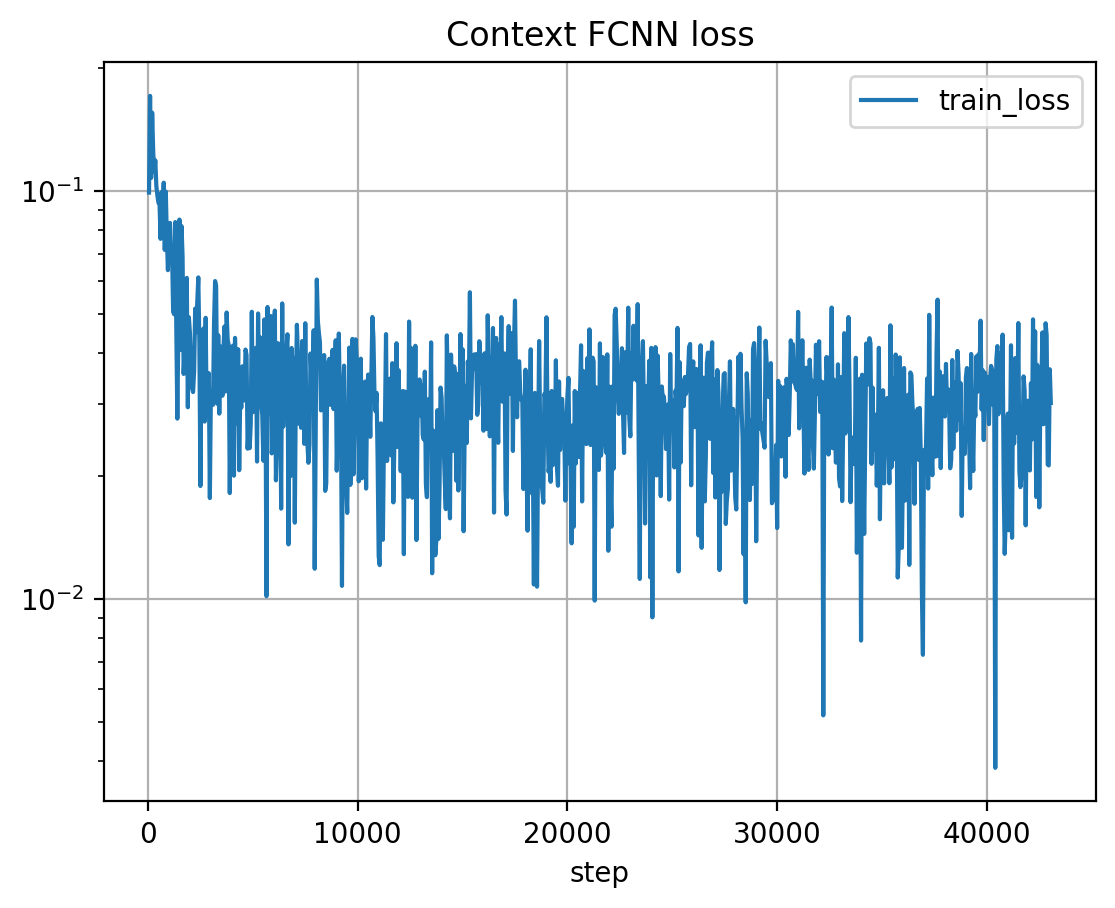

In [9]:
import pandas as pd

df_simple_metrics = pd.read_csv("logs/context_net/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="Context FCNN loss", x="step", y="train_loss", logy=True
);

In [12]:
for sample in piano_roll_dataset:
    piano_roll_sample = sample
    break
piano_roll_sample

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

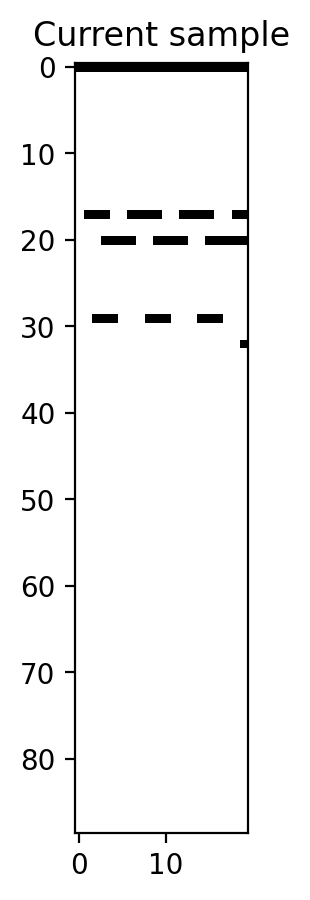

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(piano_roll_sample[0].T, cmap="binary");
plt.title("Current sample");

In [59]:
note_sequence = piano_roll_sample[0]

for i in range(40):
    next_frame = context_net.net(note_sequence[i:].unsqueeze(0))
    binary_frame = (torch.nn.Sigmoid()(next_frame) > 0.7).to(torch.float32)
    note_sequence = torch.concat([note_sequence, binary_frame])

predicted_sequence = note_sequence.detach().numpy()

In [62]:
predicted_sequence.shape

(60, 89)

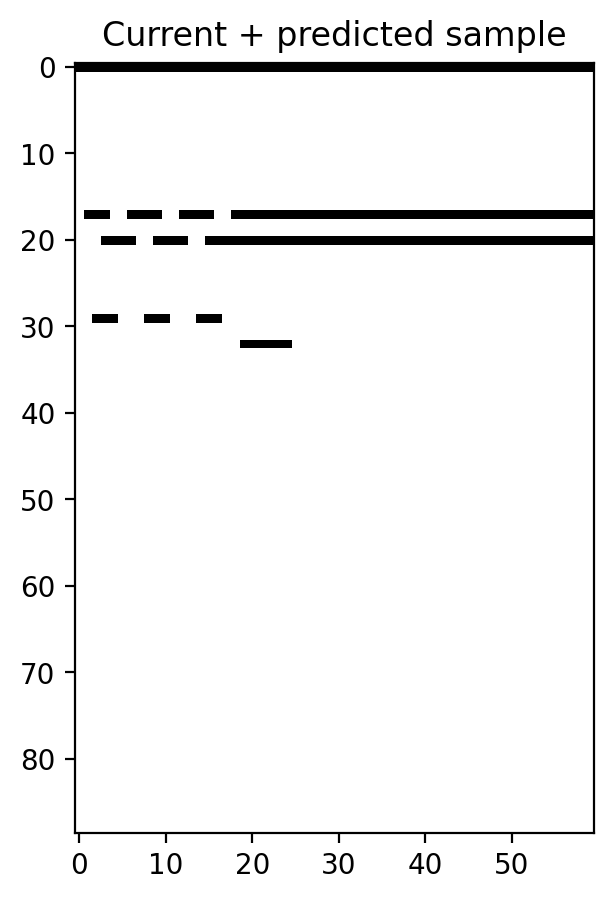

In [63]:
plt.figure(figsize=(5, 5))
plt.imshow(predicted_sequence.T, cmap="binary");
plt.title("Current + predicted sample");

In [35]:
binary_frame = (torch.nn.Sigmoid()(next_frame) > 0.7).to(torch.float32)
binary_frame

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [39]:
note_sequence[20] = binary_frame

IndexError: index 20 is out of bounds for dimension 0 with size 20

In [47]:
torch.column_stack([note_sequence, binary_frame])

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 20 but got size 1 for tensor number 1 in the list.

In [50]:
note_sequence.shape

torch.Size([20, 89])

In [51]:
binary_frame.shape

torch.Size([1, 89])

In [53]:
torch.concat([note_sequence, binary_frame]).shape

torch.Size([21, 89])

<Axes: >

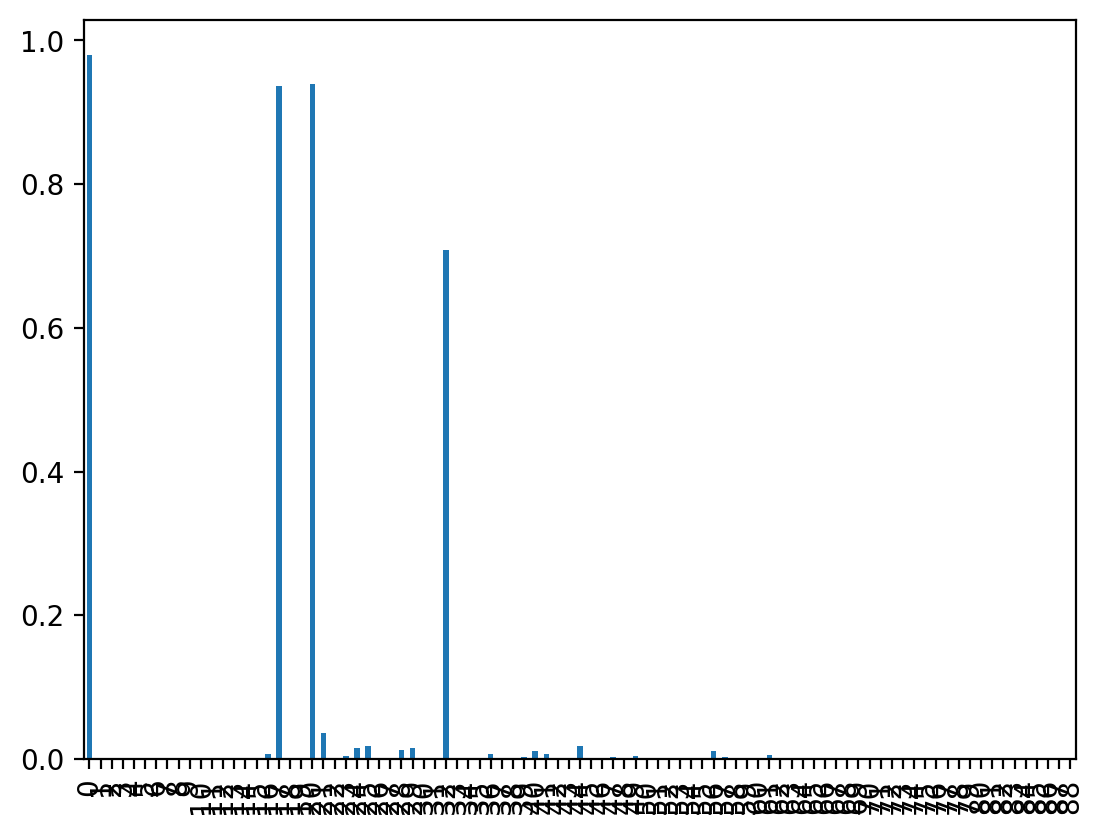

In [31]:
pd.Series(torch.nn.Sigmoid()(next_frame).detach().numpy()[0]).plot.bar()